In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import savetxt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
  
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

import re

[nltk_data] Downloading package wordnet to /Users/Miguel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
stop_words = set(stopwords.words('english'))
porter = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

In [2]:
# Dominik
path = "/home/dominik/BSE/Term2/TextMining1/Project/Data/"
out_path = "/home/dominik/BSE/Term2/TextMining1/Project/Analysis_plots/"

# Miguel
path = "/Users/Miguel/Desktop/Term2/Intro NLP/text-mining-final-project/"
out_path = "/Users/Miguel/Desktop/Term2/Intro NLP/text-mining-final-project/"


# Load Data

## Create one csv file

In [3]:
df1 = pd.read_csv(path + "all_articles_2015_2016.csv") #2015-2016
df2 = pd.read_csv(path + "all_articles_2017_2018.csv") #2017-2018
df3 = pd.read_csv(path + "all_articles_2019.csv") # 2019
df4 = pd.read_csv(path + "all_articles_2020.csv") # 2020
df5 = pd.read_csv(path + "all_articles_2021_2022.csv") # 2021-2022

FileNotFoundError: [Errno 2] No such file or directory: '/Users/Miguel/Desktop/Term2/Intro NLP/text-mining-final-project/all_articles_2015_2016.csv'

In [ ]:
df = pd.concat([df1, df2, df3, df4, df5])

In [ ]:
# Check that concatination worked correctly
df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0] == df.shape[0]

In [ ]:
# Check that we have no duplicates
df.drop_duplicates().shape[0] == df.shape[0]

In [ ]:
# Exclude rows with NaN in text column
print(sum(df["story_text"].isna()))
df = df.loc[~df["story_text"].isna(),]

In [ ]:
df.shape

In [4]:
df.to_csv(path + "all_data.csv", index=False)

NameError: name 'df' is not defined

## Load Data Frame

In [58]:
# Load data frame containing all periods
df = pd.read_csv(path + "all_data.csv")

## Some checks of data consistency

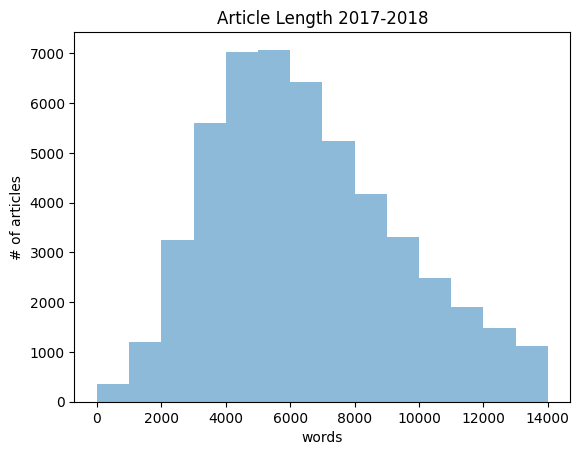

In [59]:
# Check to see distribution of lengths of articles.
length_data = [len(tex) for tex in df['story_text']]

# fixed bin size
bins = np.arange(-0, 15000, 1000) # fixed bin size

plt.hist(length_data, bins=bins, alpha=0.5)
plt.title('Article Length 2017-2018')
plt.xlabel('words')
plt.ylabel('# of articles')

plt.show()

In [60]:
df.head(2)

,Unnamed: 0.1,url,title,subtitle,n_sections,n_paragraphs,section_titles,story_text,claps,responses,reading_time,publication,date,year,Unnamed: 0
0,0,https://towardsdatascience.com/d3-js-the-custo...,D3.js —Use it as Custom modular Bundle Now!!,NaN,2,17,['D3.js —Use it as Custom modular Bundle Now!!...,It’s a Big Data world today and we deal with n...,133.0,2,3,Towards Data Science,2016-08-02,2016,NaN
1,1,https://towardsdatascience.com/machine-learnin...,Machine learning algorithm vs. Actuarial scien...,NaN,3,19,['Machine learning algorithm vs. Actuarial sci...,"In today’s fast paced world of technology, an ...",65.0,0,4,Towards Data Science,2016-08-05,2016,NaN


<AxesSubplot: >

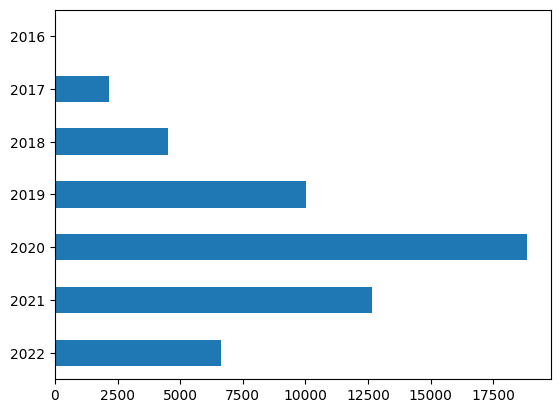

In [61]:
# Towards Data Science was launched on Medium on October of 2016, so we basically have all the data.
df.year.value_counts().sort_index(ascending=False).plot(kind = 'barh')

# Preprocessing

## Exclude months with too little observations

In [62]:
# create a column for month
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df["month"] = df.date.dt.month

In [63]:
# exclude all observations from 2016
df = df.loc[df.year != 2016,]

# exclude observations from Jan and Feb 2017
drop_index = df.loc[(df.year == 2017) & ((df.month == 1) | (df.month == 2)),].index
df = df.loc[~df.index.isin(drop_index),]
df.index = range(df.shape[0])

## Functions for basic pre-processing

In [25]:
#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [26]:
#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
def tokenize(text, modulation):
    tokens = re.split(r'\W+', text)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if lowers not in stop_words:
            if re.search('[a-zA-Z]', lowers):
                if modulation==0:
                    stems.append(lowers)
                if modulation==1:
                    stems.append(porter.stem(lowers))
                if modulation==2:
                    stems.append(lmtzr.lemmatize(lowers))
                stems.append(" ")
    return "".join(stems)

In [27]:
# create proprocessed text
def preprocessing(df, column, modulation):
    corpus = []
    for i, text in enumerate(df[column]):
        processed_text = tokenize(text, modulation)
        corpus.append(processed_text)
    return corpus

In [28]:
def exclude_series(series, pattern):
    for i, string in enumerate(series):
        string = re.sub(pattern, "", string)
        series[i] = string
    return series

Creating columns for the preprocessed text using two different approaches. One using stemming and the other using lemmatizing

In [29]:
# preprocess text and titles using stemming
df["title_preprocessed_stem"] = preprocessing(df, "title", 1)
df["title_preprocessed_lem"] = preprocessing(df, "title", 2)

# preprocess text and titles using lemmatizing
#df["text_preprocessed_lem"] = preprocessing(df, "story_text", 2)
#df["text_preprocessed_stem"] = preprocessing(df, "story_text", 1)

In [19]:
# exclusing the monthly selection
df["title_preprocessed_stem"] = exclude_series(df["title_preprocessed_stem"], r"select [a-z]+")
df["title_preprocessed_lem"] = exclude_series(df["title_preprocessed_lem"], r"selection [a-z]+")

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_91755/2332994317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[i] = string


In [20]:
# exclude entries where the preprocessed title is not a string
df = df.loc[df['title_preprocessed_stem'].apply(lambda x: isinstance(x,str)),]
df = df.loc[df['title_preprocessed_lem'].apply(lambda x: isinstance(x,str)),]

In [21]:
# reset index
df.index = range(df.shape[0])

In [22]:
df.to_csv(path + "data_all_preprocessed.csv", index = False)

## Create text per month

In [64]:
df = pd.read_csv(path + "data_all_preprocessed.csv")

In [65]:
# exclude entries where the preprocessed title is not a string
df = df.loc[df['title_preprocessed_lem'].apply(lambda x: isinstance(x,str)),]

# reset index
df.index = range(df.shape[0])

In [66]:
# create one string containing all titles for each month
df_month_title_pre = df.groupby([df.year, df.month])['title_preprocessed_lem'].apply(lambda x: ','.join(x)).reset_index()

# create one string containing all texts for each month
#df_month_text_pre = df.groupby([df.year, df.month])['text_preprocessed_lem'].apply(lambda x: ','.join(x)).reset_index()

In [67]:
df_month_title_pre = df_month_title_pre.rename(columns={"title_preprocessed_lem":"title_preprocessed"})
#df_month_text_pre = df_month_text_pre.rename(columns={"text_preprocessed_lem":"text_preprocessed"})

In [68]:
# save files per month
df_month_title_pre.to_csv(path + "month_title_preprocessed.csv", index = False)
#df_month_text_pre.to_csv(path + "month_text_preprocessed.csv", index = False)

# TF-IDF

In [10]:
df_month_title_pre = pd.read_csv(path + "month_title_preprocessed.csv")
#df_month_text_pre = pd.read_csv(path + "month_text_preprocessed.csv")

Using the sklearn library with absolute frequencies

In [11]:
# Creating a token count matrix for all tokens (including ngrams) for a given series
def token_count_matrix(series,ngram):
    cv = CountVectorizer(ngram_range=ngram)
    X = cv.fit_transform(series)
    X = X.todense()
    token_counts = pd.DataFrame(X)
    token_counts.columns = cv.get_feature_names_out()
    return token_counts

In [12]:
# Creating a tfidf matrix for a given series of texts
def create_tfidf(series, n_range, norm):
    cv = TfidfVectorizer(norm=norm, max_df = 0.5, ngram_range = n_range)
    cv.fit(series)
    vectorized_text=cv.transform(series)
    vectorized_text = vectorized_text.todense()
    tfidf = pd.DataFrame(vectorized_text)
    tfidf.columns = cv.get_feature_names_out()
    tfidf_t = tfidf.T
    return tfidf_t

In [13]:
# Custom TF-IDF function using relative frequency
def tfidf_man(word_count_matrix, df_max):
    # tf calculation
    word_count_matrix_t = word_count_matrix.T
    tf_rel_t = word_count_matrix_t / word_count_matrix_t.sum() # calculate the relative word frequency
    tf_rel = tf_rel_t.T
        
    # idf calculation
    n = len(word_count_matrix_t.columns)
    pos = word_count_matrix > 0
    pos_sum = pos.sum()
    dft = np.log(n / pos_sum)
    
    # set dft equal to zero for words that appear in all 
    dft[dft > n*df_max] = 0
    
    tfidf_t = tf_rel * dft
    tfidf = tfidf_t.T
       
    return tfidf

In [14]:
# TF-IDF scores per month
tfidf_abs = create_tfidf(df_month_title_pre["title_preprocessed"], (1,2), None)
tfidf_abs_mean = tfidf_abs.mean()

# TF-IDF score per month l1 normalization
tfidf_abs_l1 = create_tfidf(df_month_title_pre["title_preprocessed"], (1,2), "l1")
tfidf_abs_l1_mean = tfidf_abs_l1.mean()

# TF-IDF score per month l2 normalization
tfidf_abs_l2 = create_tfidf(df_month_title_pre["title_preprocessed"], (1,2), "l2")
tfidf_abs_l2_mean = tfidf_abs_l2.mean()

# Length of all titles per month
total_title_length = pd.Series(df_month_title_pre["title_preprocessed"].apply(lambda x: len(x)).values)

In [15]:
# Extract month and year for each observation
df_date = df_month_title_pre[["year", "month"]]
df_date["day"] = np.repeat(1,len(df_date.year))
dates = pd.to_datetime(df_date).dt.to_period('M')

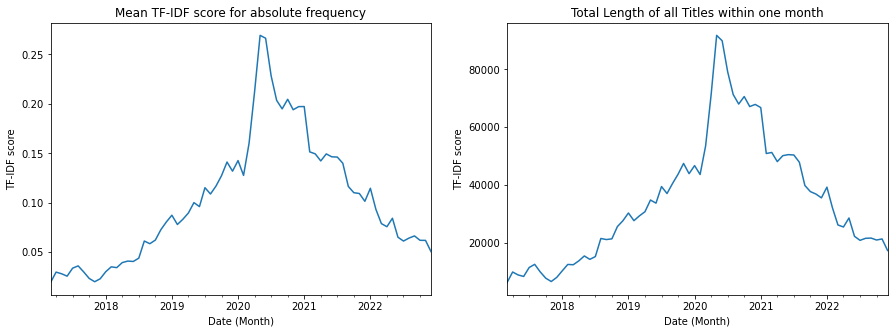

In [16]:
# Define the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot the first graph on the first axis
tfidf_abs_mean = tfidf_abs.mean()
tfidf_abs_mean.index = dates
tfidf_abs_mean.plot.line(ax=axes[0])
axes[0].set_xlabel("Date (Month)")
axes[0].set_ylabel("TF-IDF score")
axes[0].set_title("Mean TF-IDF score for absolute frequency")

# Plot the second graph on the second axis
total_title_length.index = dates
total_title_length.plot.line(ax=axes[1])
axes[1].set_xlabel("Date (Month)")
axes[1].set_ylabel("TF-IDF score")
axes[1].set_title("Total Length of all Titles within one month")

# Show the plots
plt.savefig(out_path + "need_for_normalization.png")
plt.show()

In [17]:
# create tfid matrix with relative frequencies
token_counts = token_count_matrix(df_month_title_pre["title_preprocessed"], (1,2))
tfidf_rel = tfidf_man(token_counts, 0.5)
tfidf_rel.columns = dates
tfidf = tfidf_rel  # define the tfidf matrix which we use later in the code

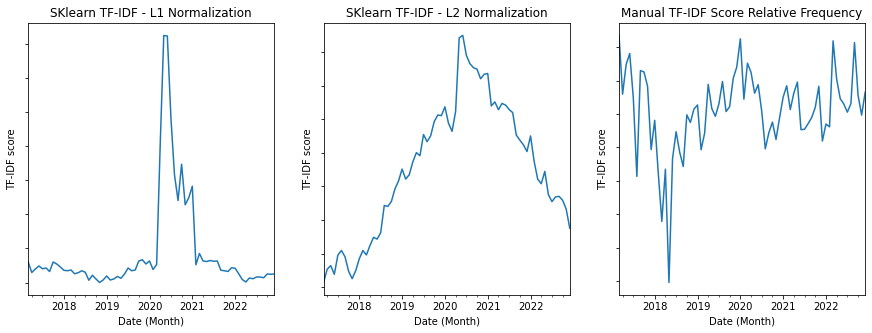

In [18]:
# Define the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])


# Plot the first graph on the first axis
tfidf_abs_l1_mean = tfidf_abs_l1.mean()
tfidf_abs_l1_mean.index = dates
tfidf_abs_l1_mean.plot.line(ax=axes[0])

axes[0].set_xlabel("Date (Month)")
axes[0].set_ylabel("TF-IDF score")
axes[0].set_title("SKlearn TF-IDF - L1 Normalization")


# Plot the first graph on the first axis
tfidf_abs_l2_mean = tfidf_abs_l2.mean()
tfidf_abs_l2_mean.index = dates
tfidf_abs_l2_mean.plot.line(ax=axes[1])
axes[1].set_xlabel("Date (Month)")
axes[1].set_ylabel("TF-IDF score")
axes[1].set_title("SKlearn TF-IDF - L2 Normalization")

# Plot the second graph on the second axis
tfidf_man_mean = tfidf.mean()
tfidf_man_mean.index = dates
tfidf_man_mean.plot.line(ax=axes[2])
axes[2].set_xlabel("Date (Month)")
axes[2].set_ylabel("TF-IDF score")
axes[2].set_title("Manual TF-IDF Score Relative Frequency")

# Show the plots
plt.savefig(out_path + "normalization_approaches.png")
plt.show()

In [88]:
# TF-IDF score per month l1 normalization
tfidf_abs_l1 = create_tfidf(df_month_text_pre["text_preprocessed"], (1,2), "l1")
tfidf_abs_l1_mean = tfidf_abs_l1.mean()

# TF-IDF score per month l2 normalization
tfidf_abs_l2 = create_tfidf(df_month_text_pre["text_preprocessed"], (1,2), "l2")
tfidf_abs_l2_mean = tfidf_abs_l2.mean()

KeyboardInterrupt: 

## Exploratory analysis with the title TF-IDF scores

### Do tf-idf scores of the titles correlate with real world events?

World Cup

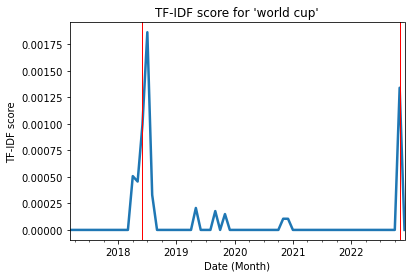

In [19]:
world_cup = tfidf.T["world cup"]

# Create the line plot
fig, ax = plt.subplots()
world_cup.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'world cup'")

# Add vertical lines
ax.axvline(x='2018-06-01', color='red', linestyle='-', linewidth=1)
ax.axvline(x='2022-11-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_worldcup.png")
plt.show()

Alphafold

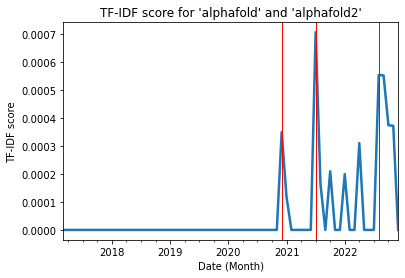

In [20]:
alphafold = tfidf.T["alphafold"] + tfidf.T["alphafold2"]

# Create the line plot
fig, ax = plt.subplots()
alphafold.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'alphafold' and 'alphafold2'")

# 30th November 2020: AlphaFold2 wins CASP14 by a huge margin and is recognised as a solution to the 50-year-old 
# “protein-folding problem”
ax.axvline(x='2020-12-01', color='red', linestyle='-', linewidth=1)

# 15th July 2021: Nature publishes AlphaFold’s detailed methodology in the paper “Highly accurate protein 
# structure prediction with AlphaFold”
ax.axvline(x='2021-07-01', color='red', linestyle='-', linewidth=1)

# 28th July 2022: DeepMind expands the AlphaFold Protein Structure Database from nearly 1 million to over 
# 200 million structures, including predictions for most proteins in UniProt.
ax.axvline(x='2022-08-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_alphafold.png")
plt.show()

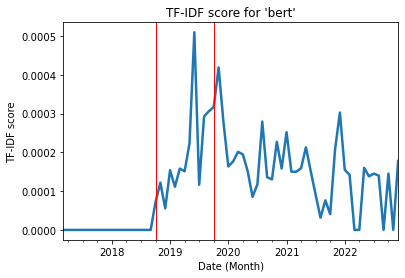

In [21]:
bert = tfidf.T["bert"]

# Create the line plot
fig, ax = plt.subplots()
bert.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'bert'")

# Add vertical lines
# Devlin, Jacob; Chang, Ming-Wei; Lee, Kenton; Toutanova, Kristina (11 October 2018). 
# "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"
ax.axvline(x='2018-10-01', color='red', linestyle='-', linewidth=1)

# On October 25, 2019, Google announced that they had started applying BERT models for 
# English language search queries within the US
ax.axvline(x='2019-10-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_bert.png")
plt.show()

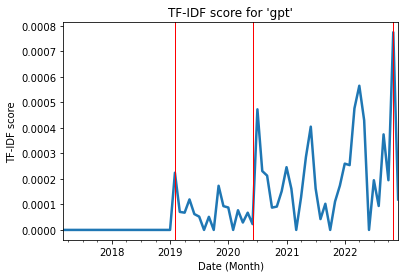

In [22]:
gpt = tfidf.T["gpt"]

# Create the line plot
fig, ax = plt.subplots()
gpt.plot.line(ax=ax, linewidth=2.5)
ax.set_xlabel("Date (Month)")
ax.set_ylabel("TF-IDF score")
ax.set_title("TF-IDF score for 'gpt'")

# Add vertical lines

# GPT-2 was first announced in February 2019
ax.axvline(x='2019-02-01', color='red', linestyle='-', linewidth=1)

# OpenAI planned to allow access through a paid cloud API after a two-month free private beta 
# that began in June 2020
ax.axvline(x='2020-06-01', color='red', linestyle='-', linewidth=1)

#ChatGPT
ax.axvline(x='2022-11-01', color='red', linestyle='-', linewidth=1)

plt.savefig(out_path + "tfidf_gpt.png")
plt.show()

### Do TF-IDF scores allow us to understand which topics are the most important in a month?

Get the word with the highest tfidf score per month

In [23]:
# reset index
df.index = range(df.shape[0])

In [24]:
top10s = []
top5s = []
for col in tfidf.columns:
    top_10 = list(tfidf[col].sort_values(ascending=False).head(10).index)
    top10s.append(top_10)
    
    top_5 = list(tfidf[col].sort_values(ascending=False).head(5).index)
    top5s.append(top_5)

In [25]:
topwords = pd.DataFrame(data={"date":tfidf.columns, "top5":top5s, "top10":top10s})

In [26]:
topwords.loc[topwords["date"] == "2017-03", "top10"].values[0]

['pesticide',
 'driven level',
 'state artificial',
 'detection self',
 'weekly selection',
 'udacity self',
 'car nanodegree',
 'level using',
 'intelligence part',
 'pattern strong']

In [27]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [28]:
df["top5"] = 0
df["top10"] = 0

In [29]:
for i in range(df.shape[0]-1):
    for j in range(len(tfidf.columns)-1):
        top5_words = topwords.loc[topwords["date"] == tfidf.columns[j], "top5"].values[0]
        top10_words = topwords.loc[topwords["date"] == tfidf.columns[j], "top10"].values[0]
        
        curr_month = tfidf.columns[j].to_timestamp()
        next_month = tfidf.columns[j+1].to_timestamp()
        article_date = df.loc[i,"date"]
        
        if (article_date >= curr_month) & (article_date < next_month):
            
            # top 5
            in_text = [ngram in df["title_preprocessed_lem"][i] for ngram in top5_words]
            in_text = sum(in_text * 1)
            if in_text != 0:
                df.loc[i,"top5"] = in_text
            
            # top 10
            in_text = [ngram in df["title_preprocessed_lem"][i] for ngram in top10_words]
            in_text = sum(in_text * 1)
            if in_text != 0:
                df.loc[i, "top10"] = in_text

In [30]:
df_top = df[['url', 'title', 'n_sections', 'n_paragraphs', 'reading_time','title_preprocessed_lem', 'top5', 'top10']]

In [31]:
df_top.top10.value_counts()

0    52911
1     1290
2      337
3      127
4       66
5       19
6        9
8        8
7        3
Name: top10, dtype: int64

In [45]:
df[["title", "title_preprocessed_lem"]]

,title,title_preprocessed_lem
0,Process Blog #6 — Visualization,process blog visualization
1,Data Manipulation with N-Queens,data manipulation n queen
2,A candid conversation about data science with ...,candid conversation data science allen downey
3,The 3 Things About Data You Probably Don’t Kno...,thing data probably know need
4,Exploratory analysis and regression model help...,exploratory analysis regression model helping ...
...,...,...
54765,What Makes Us Different from AI?,make u different AI
54766,2 Different Replace Functions of Python Pandas,different replace function python panda
54767,The Importance of Cross Validation in Machine ...,importance cross validation machine learning
54768,How to Visualize Monthly Expenses in a Compreh...,visualize monthly expense comprehensive way de...


In [116]:
df_top.to_csv("df_top_tfidf.csv")

NameError: name 'df_top' is not defined

Identify the word per month which had the largest increase in tfidf value

In [56]:
all_rankings = pd.DataFrame(data = {"name": tfidf.index})

for col in tfidf.columns:
    current_rank = tfidf[col].sort_values(ascending=False)[tfidf[col].sort_values(ascending=False) > 0]
    current_rank = pd.DataFrame(data={"name":current_rank.index, str(col): current_rank.values})
    all_rankings = all_rankings.merge(current_rank, how="left", on="name")
    
all_rankings = all_rankings.fillna(0)

In [59]:
for i, col in enumerate(tfidf.columns):
    if i < 71:
        curr_month = all_rankings.columns[i+2]
        last_month = all_rankings.columns[i+1]

        diff = all_rankings[curr_month] - all_rankings[last_month]
        largest_increase = diff.index[diff == diff.max()]
        if len(largest_increase) == 1:
            largest_increase_word = all_rankings.iloc[largest_increase[0]].values[0]
            print("biggest increase " + str(last_month) + " to " + str(curr_month) + ": " + largest_increase_word)

biggest increase 2017-03 to 2017-04: m2m day
biggest increase 2017-06 to 2017-07: simplifi part
biggest increase 2017-07 to 2017-08: start bioinformat
biggest increase 2017-08 to 2017-09: ted
biggest increase 2017-09 to 2017-10: machin intuit
biggest increase 2017-12 to 2018-01: numpi implement
biggest increase 2018-01 to 2018-02: interact code
biggest increase 2018-02 to 2018-03: indian food
biggest increase 2018-03 to 2018-04: season episod
biggest increase 2018-05 to 2018-06: paper summari
biggest increase 2018-06 to 2018-07: cvpr paper
biggest increase 2018-08 to 2018-09: project pendragon
biggest increase 2018-09 to 2018-10: reduct dummi
biggest increase 2018-11 to 2018-12: launch scale
biggest increase 2019-02 to 2019-03: measur accuraci
biggest increase 2019-05 to 2019-06: equat code
biggest increase 2019-06 to 2019-07: moon land
biggest increase 2019-07 to 2019-08: use orang
biggest increase 2019-09 to 2019-10: chart chart
biggest increase 2019-10 to 2019-11: skate world
bigges

IndexError: index 71 is out of bounds for axis 0 with size 71

Using the entire text for tfidf analysis

In [ ]:
# create tfid matrix with relative frequencies
token_counts = token_count_matrix(df_month_story_text["text_preprocessed"], (1,1))

In [ ]:
tfidf_rel = tfidf_man(token_counts, 0.5)
tfidf_rel.columns = dates
tfidf = tfidf_rel

In [ ]:
tfidf

## LDA

In [32]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')

docs = df['story_text'] # map(unicode, df['original_text'])

[nltk_data] Downloading package wordnet to /Users/Miguel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
# Tokenize the documents.

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_91755/198452781.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = docs[idx].lower()  # Convert to lowercase.
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_91755/198452781.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.


In [34]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# # Stem documents (to compare preprocessing)
# docs = [[porter.stem(token) for token in doc] for doc in docs] 

In [35]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [36]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)


In [37]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [38]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 31827
Number of documents: 54840


In [39]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [40]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.2096.


In [41]:
# visualize the topics with a dataframe

avg_score = []
topic_list = []
for topic in top_topics:
    topic_i = []
    avg_score.append(topic[1])
    for word in topic[0]:
        topic_i.append(word[1])
    topic_list.append(topic_i)
        

In [42]:
df_tops  = pd.DataFrame(topic_list)
df_tops.insert(0, "avg_score", avg_score)
df_tops.to_csv("LDA_topics.csv")
df_tops

,avg_score,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,-0.801325,science,me,re,thing,project,don,question,scientist,good,...,people,think,lot,learn,might,problem,could,job,something,go
1,-0.950473,ai,system,business,product,user,team,company,customer,process,...,machine_learning,solution,decision,tool,human,may,problem,approach,technology,information
2,-0.984823,network,layer,training,neural,image,function,input,deep,neural_network,...,output,weight,gradient,deep_learning,parameter,architecture,size,batch,train,feature
3,-1.129513,feature,dataset,prediction,class,training,algorithm,machine_learning,tree,test,...,classification,metric,score,accuracy,decision,train,validation,regression,method,classifier
4,-1.246622,were,year,country,game,map,day,analysis,player,over,...,average,had,rate,been,could,city,area,people,per,team
5,-1.301005,file,python,run,create,command,library,package,project,user,...,api,database,step,notebook,environment,sql,tool,application,app,table
6,-1.341175,distribution,probability,sample,test,random,variable,estimate,equation,hypothesis,...,function,parameter,error,variance,given,statistic,difference,normal,statistical,population
7,-1.348092,plot,variable,point,series,dataset,linear,regression,time_series,cluster,...,analysis,chart,visualization,feature,price,column,correlation,method,distance,below
8,-1.368046,function,column,method,list,python,row,table,type,object,...,algorithm,panda,state,node,array,dataframe,element,return,name,following
9,-1.625089,image,word,text,language,task,sentence,vector,transformer,topic,...,dataset,object,trained,gpt,attention,embeddings,nlp,representation,token,training


In [43]:
# load the above df from 
df_tops = pd.read_csv(path + "LDA_topics_lemmatize.csv")

The function below will give us the top topic of each document as well as the share of that topic. Put this into a dataframe which we will groupby to make into pretty plots.

In [44]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=docs)

# Make a new dataframe with our results.
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_91755/1361661646.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8,0.5111,"were, year, country, game, map, day, analysis,...","[this, week, our, sprint, wa, focused, around,..."
1,1,9,0.6173,"function, column, method, list, python, row, t...","[how, we, perceive, and, by, extension, how, w..."
2,2,7,0.3892,"science, me, re, thing, project, don, question...","[where, we, discus, how, attitude, towards, no..."
3,3,3,0.5356,"ai, system, business, product, user, team, com...","[in, at, the, xerox, world, conference, held, ..."
4,4,8,0.5189,"were, year, country, game, map, day, analysis,...","[alerta, zika, wa, collaborative, event, to, e..."
5,5,1,0.2633,"plot, variable, point, series, dataset, linear...","[udacity, sdcnd, when, driving, car, two, very..."
6,6,2,0.2944,"feature, dataset, prediction, class, training,...","[semantic, similarity, is, basically, deciding..."
7,7,7,0.3221,"science, me, re, thing, project, don, question...","[welcome, to, the, mom, report, hi, mom, if, t..."
8,8,4,0.3398,"image, word, text, language, task, sentence, v...","[code, implementation, here, at, this, point, ..."
9,9,7,0.7988,"science, me, re, thing, project, don, question...","[a, data, scientist, one, consideration, to, m..."


In [69]:
# Add our new data to our original dataframe.
df['dominant_topic'] = df_dominant_topic['Dominant_Topic']
df['keywords'] = df_dominant_topic['Keywords']

In [70]:
# This performs a groupby of our dataframe and aggregates our data by year, month and topic so that we
# can make some pretty plots.

df2 = df.groupby(['year', 'month', 'dominant_topic','keywords'])['story_text'].agg('count').reset_index()
df2 = df2[['year','month','dominant_topic', 'story_text', 'keywords']]
total_per_month = df.groupby(['year', 'month'])['story_text'].agg('count').reset_index()
total_per_month['story_text']
df3 = df2.merge(total_per_month, on=['year','month'], how='left', indicator=True)
df3['top_prop'] = [df3['story_text_x'][i]/df3['story_text_y'][i] for i in range(len(df3))]
df3

,year,month,dominant_topic,story_text_x,keywords,story_text_y,_merge,top_prop
0,2017,3,0,11,"network, layer, training, neural, image, funct...",159,both,0.069182
1,2017,3,1,5,"plot, variable, point, series, dataset, linear...",159,both,0.031447
2,2017,3,2,6,"feature, dataset, prediction, class, training,...",159,both,0.037736
3,2017,3,3,36,"ai, system, business, product, user, team, com...",159,both,0.226415
4,2017,3,4,10,"image, word, text, language, task, sentence, v...",159,both,0.062893
...,...,...,...,...,...,...,...,...
695,2022,12,5,23,"distribution, probability, sample, test, rando...",382,both,0.060209
696,2022,12,6,74,"file, python, run, create, command, library, p...",382,both,0.193717
697,2022,12,7,40,"science, me, re, thing, project, don, question...",382,both,0.104712
698,2022,12,8,16,"were, year, country, game, map, day, analysis,...",382,both,0.041885


In [71]:
df

,Unnamed: 0.1,url,title,subtitle,n_sections,n_paragraphs,section_titles,story_text,claps,responses,reading_time,publication,date,year,Unnamed: 0,month,title_preprocessed_stem,title_preprocessed_lem,dominant_topic,keywords
0,53,https://towardsdatascience.com/process-blog-6-...,Process Blog #6 — Visualization,NaN,4,5,"['Process Blog #6 — Visualization', 'The Proce...","This week, our sprint was focused around creat...",5.0,1,3,Towards Data Science,2017-03-01,2017,NaN,3,process blog visual,process blog visualization,8,"were, year, country, game, map, day, analysis,..."
1,54,https://towardsdatascience.com/data-manipulati...,Data Manipulation with N-Queens,NaN,1,11,['Data Manipulation with N-Queens'],How we perceive and by extension how we solve ...,6.0,1,6,Towards Data Science,2017-03-02,2017,NaN,3,data manipul n queen,data manipulation n queen,9,"function, column, method, list, python, row, t..."
2,55,https://towardsdatascience.com/a-candid-conver...,A candid conversation about data science with ...,NaN,4,26,['A candid conversation about data science wit...,where we discuss 1) how attitude towards non-t...,6.0,0,8,Towards Data Science,2017-03-02,2017,NaN,3,candid convers data scienc allen downey,candid conversation data science allen downey,7,"science, me, re, thing, project, don, question..."
3,56,https://towardsdatascience.com/the-3-things-ab...,The 3 Things About Data You Probably Don’t Kno...,NaN,5,22,['The 3 Things About Data You Probably Don’t K...,"In 1977, at the Xerox World Conference held in...",23.0,1,5,Towards Data Science,2017-03-02,2017,NaN,3,thing data probabl know need,thing data probably know need,3,"ai, system, business, product, user, team, com..."
4,57,https://towardsdatascience.com/exploratory-ana...,Exploratory analysis and regression model help...,NaN,1,72,['Exploratory analysis and regression model he...,Alerta Zika! was a collaborative event to expl...,NaN,0,9,Towards Data Science,2017-03-02,2017,NaN,3,exploratori analysi regress model help fight z...,exploratory analysis regression model helping ...,8,"were, year, country, game, map, day, analysis,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54822,19293,https://towardsdatascience.com/similarities-di...,What Makes Us Different from AI?,What is the origin of new ideas?,5,43,"['What Makes Us Different from AI?', 'The Abil...",The human brain is currently the best Neural N...,277.0,15,9,Towards Data Science,2022-12-31,2022,NaN,12,make us differ ai,make u different AI,2,"feature, dataset, prediction, class, training,..."
54823,19294,https://towardsdatascience.com/2-different-rep...,2 Different Replace Functions of Python Pandas,And when to use which,5,29,['2 Different Replace Functions of Python Pand...,Pandas is a highly efficient data analysis and...,120.0,0,6,Towards Data Science,2022-12-31,2022,NaN,12,differ replac function python panda,different replace function python panda,6,"file, python, run, create, command, library, p..."
54824,19295,https://towardsdatascience.com/the-importance-...,The Importance of Cross Validation in Machine ...,Explaining why Machine Learning needs Cross Va...,7,23,['The Importance of Cross Validation in Machin...,The cross validation method is used to test tr...,92.0,0,6,Towards Data Science,2022-12-31,2022,NaN,12,import cross valid machin learn,importance cross validation machine learning,1,"plot, variable, point, series, dataset, linear..."
54825,19296,https://towardsdatascience.com/how-to-visualiz...,How to Visualize Monthly Expenses in a Compreh...,NaN,7,21,['How to Visualize Monthly Expenses in a Compr...,Visualizing the monthly cash flow isn’t new if...,69.0,0,5,Towards Data Science,2022-12-31,2022,NaN,12,visual month expens comprehens way develop san...,visualize monthly expense comprehensive way de...,9,"function, column, method, list, python, row, t..."


## LDA Plots

The plots below are made from assigning one topic to every article; specifically the topic with the largest share.

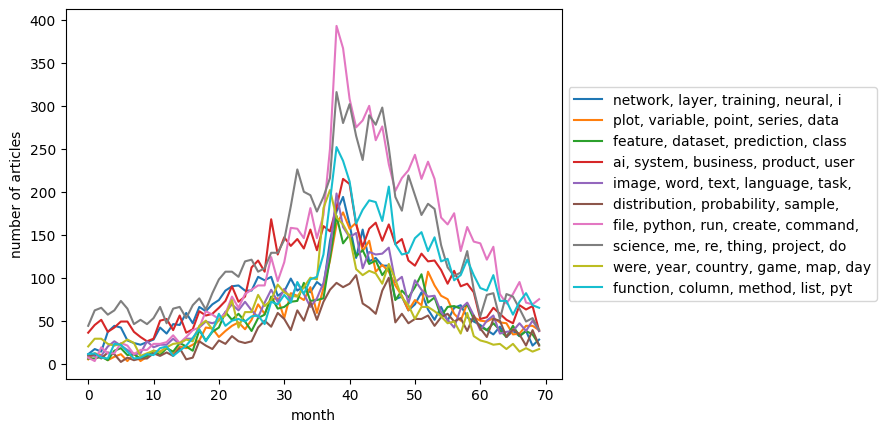

In [48]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(0,10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().story_text_x,
            label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("number of articles")
ax.legend(loc='best')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

The plot below takes into account the number of articles per month, so we can compare which topics make a greater share of articles per month. Below, we have applied a smoothing of 12 months.

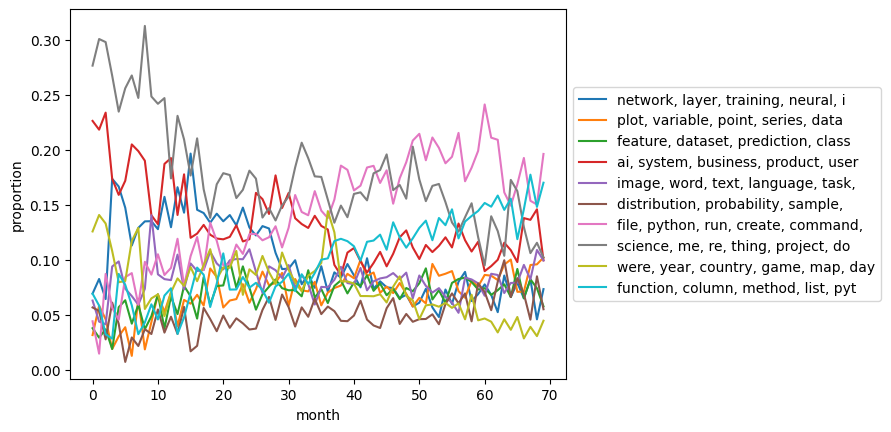

In [49]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_91755/2357110883.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['_merge', 'keywords'], dtype='object')
  ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_91755/2357110883.py:5: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['_merge', 'keywords'], dtype='object')
  ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])
/var/folders/gs/1_v5qmgn6rv2

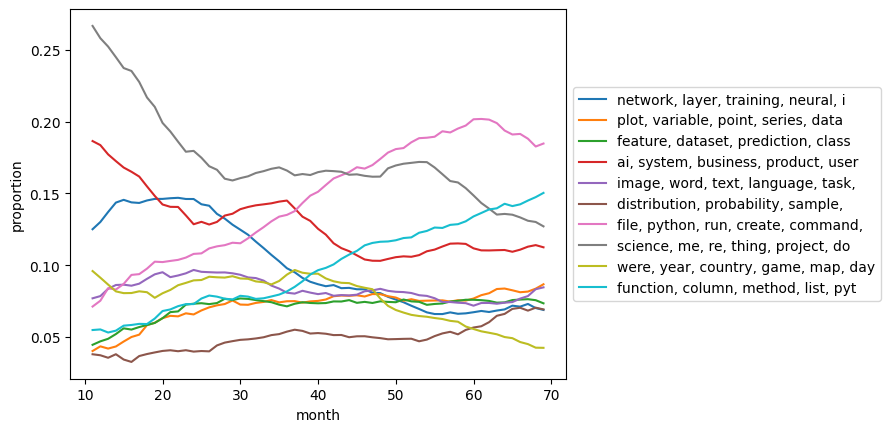

In [50]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for top in range(10):
    ax.plot(df3[df3.dominant_topic==top].rolling(window=12).mean().reset_index().top_prop,label=np.unique(df3.keywords[df3.dominant_topic==top])[0][0:35])

ax.set_xlabel("month")
ax.set_ylabel("proportion")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Regression - simple w years

In [113]:
from textstat import flesch_reading_ease
df[['date']]

,date
0,2017-03-01
1,2017-03-02
2,2017-03-02
3,2017-03-02
4,2017-03-02
...,...
54822,2022-12-31
54823,2022-12-31
54824,2022-12-31
54825,2022-12-31


In [87]:
# Compute difficulty of each article using the Flesch Reading Score.
# takes a few minutes
df['FRE']=df['story_text'].apply(lambda x : flesch_reading_ease(x))

In [114]:
# Prepare variables for regression

# count words in title and article
df['title_len'] = df['title'].apply(lambda x : len(x))
df['art_len'] = df['story_text'].apply(lambda x : len(x))
df["claps"] = df["claps"].replace(np.nan, 0)

# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['year'],dtype=np.int64)

df['date'] = df['date'].apply(pd.to_datetime) #if conversion required
df['days_since_pub'] = (pd.to_datetime('2022-12-31')-df['date']).dt.days
df['days_since_pub']

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

In [518]:
# REGRESSION

# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len',0,1,2,3,4,5,6,7,8,9,
            2016,2017,2018,2019,2020,2021,2022]
df_4_reg = df_4_reg[reg_vars]

import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients

r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.6138228776245271


/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [519]:
regression_results = pd.DataFrame({'var': reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results

,var,coefs
0,n_paragraphs,-0.081632
1,n_sections,2.750407
2,FRE,-1.386116
3,title_len,-0.429957
4,responses,117.506431
5,art_len,0.003114
6,0,20.871820
7,1,-44.801781
8,2,-0.260460
9,3,23.374985


# Regression - testing interaction terms

Try to look at the interaction terms of years and topics.

In [122]:
# create dummy variables
dum1 = pd.get_dummies(df['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df['date'],dtype=np.int64)

#add them to a dataframe with our other data
df_4_reg = pd.concat([df, dum1], axis=1)
df_4_reg = pd.concat([df_4_reg, dum2], axis=1)

In [601]:
testdf = df_4_reg

In [602]:
for i in range(0,9):
    for j in range(2016, 2023):
        testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  testdf[str(i)+"."+str(j)] = np.multiply(testdf[[i]],testdf[[j]])
/var/folders/gs/1_v5qmgn6rv2g4xtpvbhlpgm0000gn/T/ipykernel_13209/334817530.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before ap

In [611]:
# pick variables for regression
reg_vars = ['n_paragraphs','n_sections','FRE','title_len','responses',
            'art_len']
interaction_terms = list(testdf.columns[38:len(testdf.columns)])


df_4_reg = df_4_reg[interaction_terms+reg_vars]


In [609]:
import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_4_reg, df['claps'])

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients



(130.6307181788475,
 array([-2.66274893e+02,  9.29870764e+01,  3.21935126e+02, -5.08617777e+00,
        -3.67090827e+01, -7.15732459e+01, -8.28258446e+01, -5.03894654e+01,
        -8.16679744e+01, -9.25388503e+00, -4.78147493e+01, -9.48409601e+01,
        -7.81919379e+01, -8.43771826e+01, -4.42239125e+02,  3.98770067e+01,
         1.60540731e+02, -3.05814545e+01, -5.43824685e+01, -5.42833395e+01,
        -5.10822752e+01, -9.66338121e-13,  3.86697167e+01,  2.20335698e+02,
         4.14903030e+01, -1.80214771e+01, -6.54078314e+01, -8.57859429e+01,
        -1.82161391e+02, -9.98003832e+00,  3.20601178e+02,  2.79547397e+01,
        -4.61238754e+01, -6.12760737e+01, -7.52526673e+01,  3.01732349e+00,
        -8.55840501e+01,  2.07527778e+01, -1.48071202e+01, -4.84940107e+01,
        -7.11950026e+01, -7.78097234e+01, -3.55212468e+01, -7.92594532e+01,
         9.44060721e+01, -2.66502769e+01, -5.07385839e+01, -1.05770345e+02,
        -2.25392505e+02, -2.49059028e+02,  2.41240340e+01,  3.431051

In [610]:
r_sq = model.score(df_4_reg, df['claps'])
print(f"coefficient of determination: {r_sq}")

regression_results = pd.DataFrame({'var': interaction_terms+reg_vars, 'coefs': coefficients}, columns=['var', 'coefs'])
regression_results

coefficient of determination: 0.6131792085542904


,var,coefs
0,0.2016,-266.274893
1,0.2017,92.987076
2,0.2018,321.935126
3,0.2019,-5.086178
4,0.2020,-36.709083
...,...,...
64,n_sections,2.372500
65,FRE,-1.386559
66,title_len,-0.437412
67,responses,117.959589


# Regressions w TFIDF

In [268]:
# load TFIDF dataset
df_tfidf = pd.read_csv(path + "df_top_tfidf.csv")

In [269]:
df_final= df.merge(df_tfidf[['url', 'top5','top10']], how="left", on="url")

# create dummy variables
dum1 = pd.get_dummies(df_final['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df_final['date'],dtype=np.int64)

#add them to a dataframe with our other data
df_final = pd.concat([df_final, dum1], axis=1)
df_final = pd.concat([df_final, dum2], axis=1)

# count number of days since publication to account for more likes accumlated over more time.
df['date'] = df['date'].apply(pd.to_datetime) 
df['days_since_pub'] = (pd.to_datetime('2022-12-31')-df['date']).dt.days
df['days_since_pub']

0        2131
1        2130
2        2130
3        2130
4        2130
         ... 
54822       0
54823       0
54824       0
54825       0
54826       0
Name: days_since_pub, Length: 54827, dtype: int64

In [270]:
df_final[['title','keywords', 'story_text']].head(20) # just to make sure our data lines up correctly

,title,keywords,story_text
0,Process Blog #6 — Visualization,"were, year, country, game, map, day, analysis,...","This week, our sprint was focused around creat..."
1,Data Manipulation with N-Queens,"function, column, method, list, python, row, t...",How we perceive and by extension how we solve ...
2,A candid conversation about data science with ...,"science, me, re, thing, project, don, question...",where we discuss 1) how attitude towards non-t...
3,The 3 Things About Data You Probably Don’t Kno...,"ai, system, business, product, user, team, com...","In 1977, at the Xerox World Conference held in..."
4,Exploratory analysis and regression model help...,"were, year, country, game, map, day, analysis,...",Alerta Zika! was a collaborative event to expl...
5,Vehicle Detection and Distance Estimation,"plot, variable, point, series, dataset, linear...","Udacity SDCND When driving a car, two very imp..."
6,Tackling the Quora Questions dataset,"feature, dataset, prediction, class, training,...",Semantic similarity is basically deciding how ...
7,Udacity Self-Driving Car Nanodegree Project 4 ...,"science, me, re, thing, project, don, question...",Welcome to the “mom report” (Hi mom!); if tech...
8,Hamilton: A Text Analysis of the Federalist Pa...,"image, word, text, language, task, sentence, v...","Code Implementation Here At this point, you mi..."
9,Efficiency vs. Clarity,"science, me, re, thing, project, don, question...","As a data scientist, one consideration to make..."


In [271]:
df_final.columns[0:40]

Index([           'Unnamed: 0.1',                     'url',
                         'title',                'subtitle',
                    'n_sections',            'n_paragraphs',
                'section_titles',              'story_text',
                         'claps',               'responses',
                  'reading_time',             'publication',
                          'date',                    'year',
                    'Unnamed: 0',                   'month',
       'title_preprocessed_stem',  'title_preprocessed_lem',
                'dominant_topic',                'keywords',
                           'FRE',               'title_len',
                       'art_len',          'days_since_pub',
                          'top5',                   'top10',
                               0,                         1,
                               2,                         3,
                               4,                         5,
                        

In [272]:
# Remove columns we don't need from dataset.

y = df_final['claps']


# remove variables for regression
del df_final['subtitle']
del df_final['title']
#del df_final['responses']
del df_final['claps']
del df_final['story_text']
del df_final['url']
del df_final['section_titles']
del df_final['reading_time']
del df_final['publication']
del df_final['date']
del df_final['year']
del df_final['Unnamed: 0.1']
del df_final['Unnamed: 0']
del df_final['month']
del df_final['title_preprocessed_stem']
del df_final['title_preprocessed_lem']
del df_final['keywords']
del df_final['dominant_topic']

In [273]:
df_final = df_final.replace(np.nan, 0)
df_final

,n_sections,n_paragraphs,responses,FRE,title_len,art_len,days_since_pub,top5,top10,0,...,2022-12-22 00:00:00,2022-12-23 00:00:00,2022-12-24 00:00:00,2022-12-25 00:00:00,2022-12-26 00:00:00,2022-12-27 00:00:00,2022-12-28 00:00:00,2022-12-29 00:00:00,2022-12-30 00:00:00,2022-12-31 00:00:00
0,4,5,1,46.95,31,2893,2131,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11,1,61.09,31,6713,2130,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,26,0,45.49,58,9927,2130,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,22,1,60.14,60,7089,2130,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,72,0,48.94,60,10077,2130,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54824,5,43,15,58.01,32,10320,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
54825,5,29,0,66.44,46,4216,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
54826,7,23,0,60.55,54,5658,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
54827,7,21,0,59.94,87,4016,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1


In [274]:
# save file
df_final.to_csv(path + "final.csv", index = False)

import numpy as np
from sklearn.linear_model import LinearRegression


model = LinearRegression().fit(df_final, y)

intercept, coefficients = model.intercept_, model.coef_
intercept, coefficients

r_sq = model.score(df_final, y)
print(f"coefficient of determination: {r_sq}")

/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'int', 'str']. An error will be raised in 1.2.
  warnings.warn(


coefficient of determination: 0.6396790000962747


In [275]:
df_final.isna().sum()

n_sections             0
n_paragraphs           0
responses              0
FRE                    0
title_len              0
                      ..
2022-12-27 00:00:00    0
2022-12-28 00:00:00    0
2022-12-29 00:00:00    0
2022-12-30 00:00:00    0
2022-12-31 00:00:00    0
Length: 2146, dtype: int64

In [276]:
# try different regression model

import statsmodels.api as sm

x = sm.add_constant(df_final)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  claps   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     43.76
Date:                Wed, 01 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:21:13   Log-Likelihood:            -4.1642e+05
No. Observations:               54829   AIC:                         8.371e+05
Df Residuals:                   52685   BIC:                         8.562e+05
Df Model:                        2143                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -11.4812    

# Random Forest

In [261]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [262]:
# load TFIDF dataset
df_tfidf = pd.read_csv(path + "df_top_tfidf.csv")

df_final= df.merge(df_tfidf[['url', 'top5','top10']], how="left", on="url")

# create dummy variables
dum1 = pd.get_dummies(df_final['dominant_topic'], dtype=np.int64)
dum2 = pd.get_dummies(df_final['year'],dtype=np.int64)
dum3 = pd.get_dummies(df_final['month'],dtype=np.int64)


#add them to a dataframe with our other data
df_final = pd.concat([df_final, dum1], axis=1)
df_final = pd.concat([df_final, dum2], axis=1)
df_final = pd.concat([df_final, dum3], axis=1)

df['date'] = df['date'].apply(pd.to_datetime) #if conversion required
df['days_since_pub'] = (pd.to_datetime('2022-12-31')-df['date']).dt.days
df['days_since_pub']


y = df_final['claps']


# remove variables for regression
del df_final['subtitle']
del df_final['title']
del df_final['responses']
del df_final['claps']
del df_final['story_text']
del df_final['url']
del df_final['section_titles']
del df_final['reading_time']
del df_final['publication']
del df_final['date']
del df_final['year']
del df_final['Unnamed: 0.1']
del df_final['Unnamed: 0']
del df_final['month']
del df_final['title_preprocessed_stem']
del df_final['title_preprocessed_lem']
del df_final['keywords']
del df_final['dominant_topic']

df_final = df_final.replace(np.nan, 0)
df_final

,n_sections,n_paragraphs,FRE,title_len,art_len,days_since_pub,top5,top10,0,1,...,3,4,5,6,7,8,9,10,11,12
0,4,5,46.95,31,2893,2131,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,11,61.09,31,6713,2130,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,4,26,45.49,58,9927,2130,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,5,22,60.14,60,7089,2130,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1,72,48.94,60,10077,2130,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54824,5,43,58.01,32,10320,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
54825,5,29,66.44,46,4216,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1
54826,7,23,60.55,54,5658,0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,1
54827,7,21,59.94,87,4016,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [263]:
X_train, X_test, y_train, y_test = train_test_split(df_final, y, test_size=0.2, random_state=42)


In [264]:
# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [100, 250, 1000],
    'max_depth': [4, 5, 6]
}

# Instantiate a random forest regressor
rf = RandomForestRegressor()

# Instantiate a grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_train.values, y_train.values)

# Print the best hyperparameters and corresponding mean cross-validation score
print("Best hyperparameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best hyperparameters: {'max_depth': 4, 'n_estimators': 1000}
Best cross-validation score: 0.06


In [265]:
from sklearn.metrics import r2_score, mean_squared_error

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the performance of the model on the test set
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print the R^2 and mean squared error (MSE) of the model on the test set
print("R^2 score on test set: {:.2f}".format(r2))
print("Mean squared error on test set: {:.2f}".format(mse))

/usr/local/Cellar/jupyterlab/3.4.8/libexec/lib/python3.10/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


R^2 score on test set: 0.10
Mean squared error on test set: 586580.75


In [266]:
X_train.columns[18]

2017

Feature ranking:
1: days_since_pub (0.417858738403885)
2: FRE (0.18333511519326803)
3: n_paragraphs (0.1239468153997141)
4: art_len (0.09232047345739515)
5: n_sections (0.04538865787087803)
6: 2018 (0.03921179288559453)
7: 9 (0.017204510064261196)
8: 6 (0.015245091056654595)
9: 8 (0.010570124806675676)
10: 7 (0.010450923486295758)
11: top5 (0.010028338476934654)
12: title_len (0.009739437033437128)
13: 6 (0.005136679034746149)
14: 8 (0.0037659772910085603)
15: 3 (0.0036622977302438603)
16: 5 (0.003509055769359318)
17: 12 (0.0019306515837688681)
18: 1 (0.0013635110846969502)
19: 2 (0.0011304453685320544)
20: 4 (0.00103355011979608)
21: 2017 (0.0009659530019084503)
22: 2019 (0.00051841043954545)
23: 3 (0.0005163980980502561)
24: 4 (0.0004882009261352975)
25: 0 (0.0002852559644687393)
26: 10 (0.0001597592363716484)
27: 11 (0.00010621354761021498)
28: 1 (5.930063881782899e-05)
29: 5 (3.520196878449051e-05)
30: 7 (1.6485900527729723e-05)
31: 2 (9.338622400954398e-06)
32: 9 (7.29553823317637

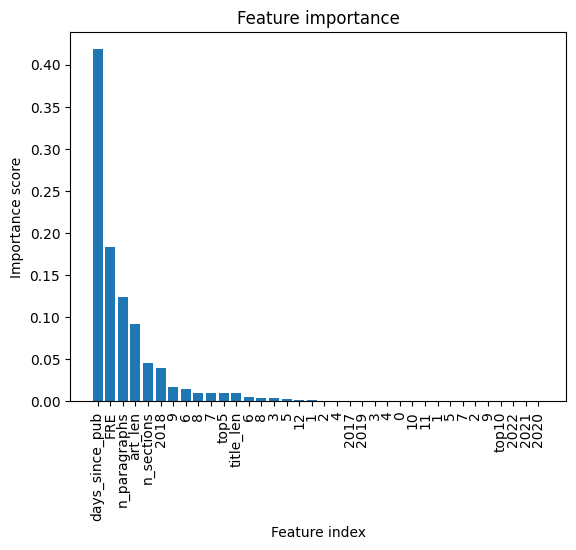

In [267]:
importances = best_model.feature_importances_

# Sort the feature importance scores in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("{}: {} ({})".format(f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importance scores
plt.figure()
plt.title("Feature importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation = 90)
plt.xlabel("Feature index")
plt.ylabel("Importance score")
plt.show()